In [1]:
import numpy as np
from nltools.data import Adjacency
import pandas as pd
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.style
import matplotlib as mpl
mpl.style.use('bmh')

from nltools.stats import align
import seaborn as sns

//anaconda2/envs/py3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
emotions = ['Afraid', 'Amused', 'Angry', 'Anxious', 'Bored', 'Disgusted',
       'Frustrated', 'Happy', 'Hopeful', 'Inspired', 'Moved', 'Proud',
       'Relieved', 'Sad', 'Surprised', 'Uncomfortable']

emotionColors = {
'Amused'  : (0.99,0.01,0.01),
'Happy'  : (0.99,0.25,0.01),
'Surprised'  : (0.99,0.44,0.01),
'Relieved'  : (0.99,0.75,0.01),
'Hopeful'  : (0.99,0.99,0.01),
'Inspired'  : (0.6,0.99,0.01),
'Proud'  : (0.01,0.99,0.56),
'Moved'  : (0.01,0.99,0.89),
'Sad'  : (0.01,0.79,0.99),
'Afraid'  : (0.01,0.44,0.99),
'Anxious'  : (0.22,0.01,0.99),
'Uncomfortable'  : (0.68,0.01,0.99),
'Angry'  : (0.99,0.01,0.91),
'Frustrated'  : (0.99,0.01,0.4),
'Disgusted' : 'brown',
'Bored' : 'gray'}


In [3]:
# Getting NAN error so dropping all NA's for now
# (will only have scan data and a few mturk participants)
p_emo_summary = pd.DataFrame()

for emo in emotions: 
    df = pd.DataFrame()

    for stim in range(108,116): 
        df_add = pd.read_csv('../MothScanAnalysis/out/cf_predictions/stim-%s_emo-%s_dilation-60.csv' % (stim, emo), index_col=0)
        df_add = df_add.sub(df_add.mean(axis=1), axis=0) #Demean data
        df = pd.concat([df, df_add], axis=1, sort=False) #Concat
        
    df.dropna(inplace=True)
    p_emo_summary = p_emo_summary.append(df)


In [4]:
data = []
for participant in list(set(p_emo_summary.index.values)): 
    p = p_emo_summary.loc[participant,:]
    p.index = emotions
    data.append(p.to_numpy())

In [5]:
n_features = 16
out = align(data, method='probabilistic_srm', n_features=n_features)

original_data = [np.dot(t.T,tm.T) for t,tm in zip(out['transformed'],out['transformation_matrix'])]

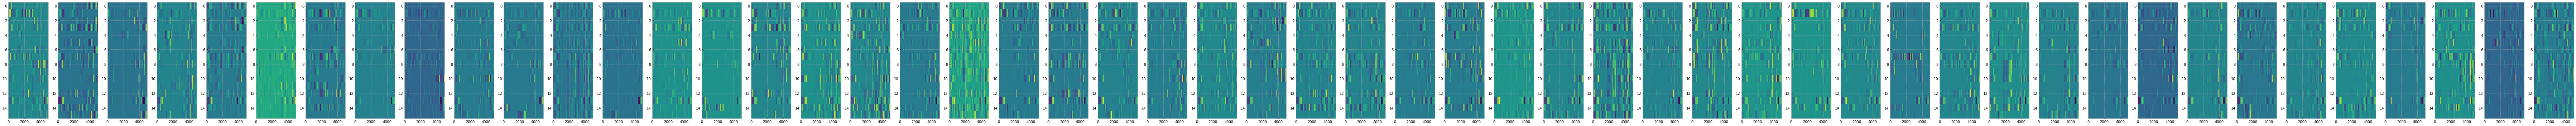

In [6]:
f,a = plt.subplots(nrows=1, ncols=52, figsize=(100,5), sharex=True, sharey=False)
# # [a[0, i].imshow(x.T, aspect='auto') for i, x in enumerate(data)]
# [a[1, i].imshow(x.T, aspect='auto') for i, x in enumerate(out['transformed'])]
[a[i].imshow(x.T, aspect='auto') for i, x in enumerate(original_data)]
# # [a[i, 0].set_ylabel(x, fontsize=16) for i, x in enumerate(['Original Voxels','Aligned Features', 'Backprojected Voxels'])]
# # [a[2, x].set_xlabel('Time', fontsize=16) for x in range(3)]
# # [a[0, x].set_title('Subject %s' % str(x+1), fontsize=16) for x in range(3)]
plt.tight_layout()

## Calculate the average loading of each feeling onto shared componenets

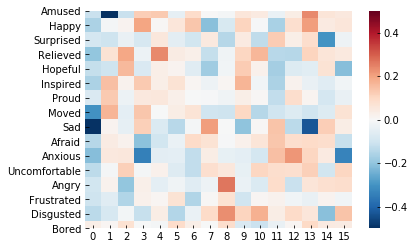

In [7]:
t_matrices = pd.DataFrame(np.mean(out['transformation_matrix'], axis=0))
t_matrices.index = emotions
t_matrices = t_matrices.reindex(emotionColors.keys())
sns.heatmap(t_matrices, cmap='RdBu_r', vmin=-.5, vmax=.5)

In [8]:
np.array(list(out['isc'].values())).std()

0.07450004459777877

## Calculate the similarity of feeling weights in each component

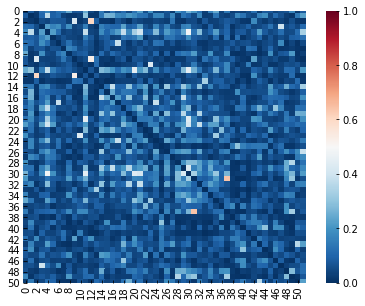

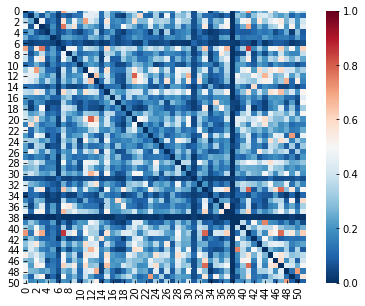

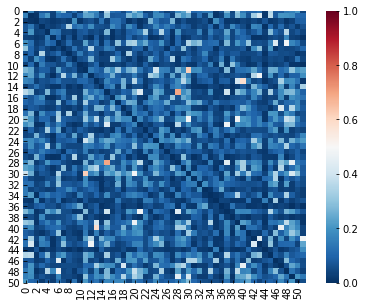

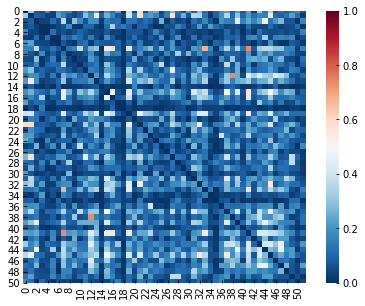

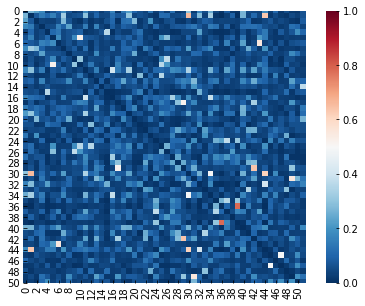

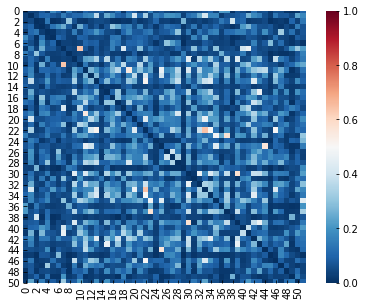

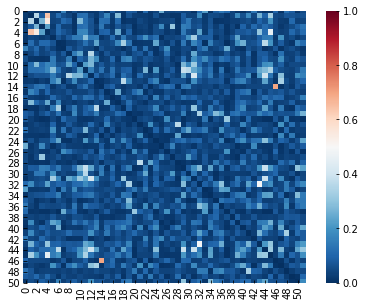

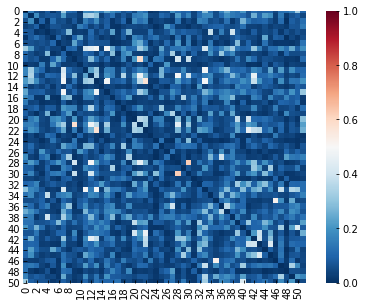

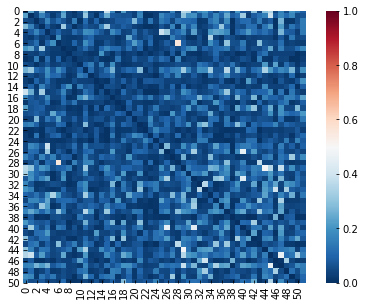

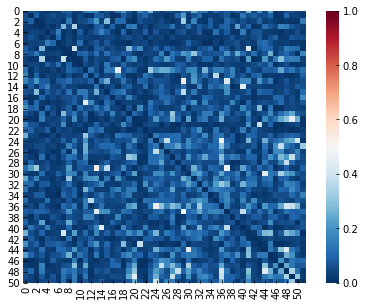

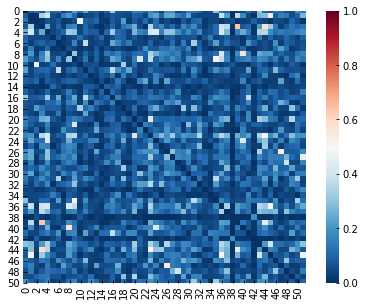

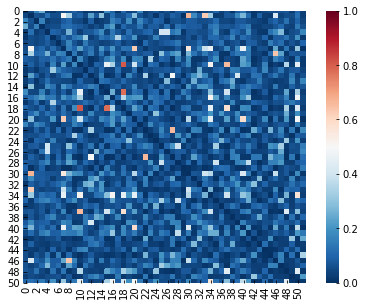

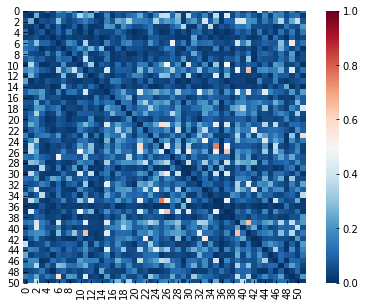

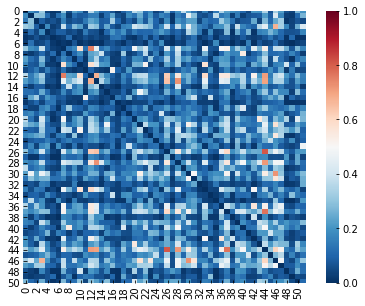

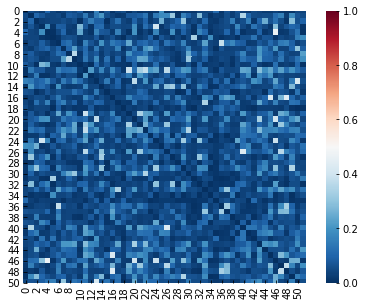

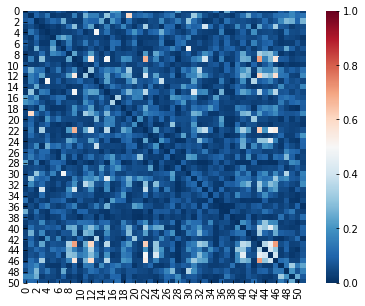

In [9]:
component_means = []

for c in range(16):

    weights = pd.DataFrame()

    for p in range(len(out['transformation_matrix'])): 
        weights = pd.concat([weights,pd.DataFrame(out['transformation_matrix'][p][c])], axis=1)

    dist = Adjacency(pairwise_distances(weights.T, metric='correlation'), matrix_type='distance')
    sim = dist.distance_to_similarity()
    f = sim.plot(cmap='RdBu_r', vmin=0, vmax=1)
    component_means.append(sim.mean())


Text(0.5, 1.0, 'Component Similarity Means')

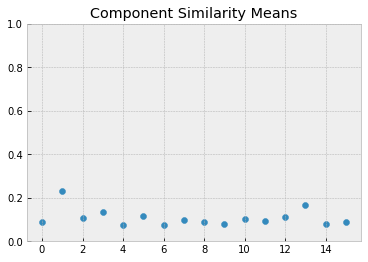

In [10]:
plt.scatter(range(len(component_means)), component_means)
plt.ylim(0,1)
plt.title('Component Similarity Means')

In [11]:
np.array(component_means).std()

0.0387218011105312